<a href="https://colab.research.google.com/github/sio-co2o2/keelingcurve_notebooks/blob/main/notebooks/plot_icecore_back_2K_ce_keelingcurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot  icecore CO2 going back 2K to 1958 and MLO after

### The Keeling Curve
https://keelingcurve.ucsd.edu

This notebook creates pdf and png plot versions.

## Import packages

In [11]:
import requests
import re
import ssl
import pandas as pd
import numpy as np
from scipy import interpolate
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import ticker
from matplotlib import rc,rcParams
from matplotlib.path import Path
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.transforms
from matplotlib import animation
from ipywidgets import widgets
from IPython.display import HTML, display
from base64 import b64encode
from PIL import Image
import urllib
import os
from cairosvg import svg2png

%matplotlib inline

In [47]:
# This import is to enable Google Colab to save files ane then download them

# This import does not exist unless the notebook is run in Google Colab
# Put in a try except block if user wants to use notebook off of Google Colab

try:
    from google.colab import files
except:
    pass

## Set directories and file names for data,  plot, and logo

In [13]:
# Get MLO data from the keelingcurve_notebooks github repository
mlo_data_file = 'https://raw.githubusercontent.com/sio-co2o2/keelingcurve_notebooks/main/data/mlo/mlo_full_record_now_span.csv'

# Get the icecore dataset back 2K years located at
# the site: https://www.ncei.noaa.gov/access/paleo-search/study/9959
# the file: https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt
# with a reference to the journal article at https://doi.org/10.1029/2006GL026152
icecore_url = 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/law/law2006.txt'

logo_file = 'https://github.com/sio-co2o2/keelingcurve_notebooks/raw/main/images/ucsd_sio_logo.svg'

plot_dir = pathlib.Path('./plots')
plot_dir.mkdir(exist_ok=True)

plot_basename = 'co2_2k_ce'

pdf_file = plot_dir / f"{plot_basename}.pdf"
png_file = plot_dir / f"{plot_basename}.png"

## Load in Data and process

### Read in MLO record

In [14]:
df_mlo = pd.read_csv(mlo_data_file, sep=',', comment='"')
df_mlo.head()

,date,co2,date_seas_adj,co2_seas_adj,date_fit,co2_fit,date_seas_adj_fit,co2_seas_adj_fit,date_filled,co2_filled,date_seas_adj_filled,co2_seas_adj_filled
0,1958.202740,315.71,1958.202740,314.43,1958.202740,316.20,1958.202740,314.90,1958.202740,315.71,1958.202740,314.43
1,1958.287671,317.45,1958.287671,315.16,1958.287671,317.30,1958.287671,314.98,1958.287671,317.45,1958.287671,315.16
2,1958.369863,317.51,1958.369863,314.70,1958.369863,317.87,1958.369863,315.06,1958.369863,317.51,1958.369863,314.70
3,1958.536986,315.87,1958.536986,315.20,1958.454795,317.26,1958.454795,315.14,1958.454795,317.26,1958.454795,315.14
4,1958.621918,314.93,1958.621918,316.21,1958.536986,315.85,1958.536986,315.22,1958.536986,315.87,1958.536986,315.20


### Get MLO Seasonally adjusted data

In [15]:
df_mlo = df_mlo[['date_seas_adj', 'co2_seas_adj']].copy()

### Remove rows with fill values NaN

In [16]:
df_mlo = df_mlo.dropna()

### Convert to numpy arrays to use for labeling relevant years in the plot

In [17]:
mlo_date = df_mlo['date_seas_adj'].to_numpy()
mlo_co2 = df_mlo['co2_seas_adj'].to_numpy()

### Read in the icecore record

In [18]:
response = requests.get(icecore_url)
file_text = response.text
text_lines = file_text.split('\n')

#### Use data from section 2 of law2006.txt: "CO2 by Core"

**Section to start with**

2\. CO2 by Core 

Gas age, Year AD 

SampleType   CO2gasAge  CO2(ppm)  Publication status


**Section to stop at**

3\. CO2 by Age 

In [19]:
start_section = [i for i in range(len(text_lines))
               if text_lines[i].startswith('2. CO2 by Core')][0]

end_section = [i for i in range(len(text_lines))
             if text_lines[i].startswith('3. CO2 by Age ')][0]

section_lines = text_lines[start_section: end_section]

# start data selection after line "SampleType   CO2gasAge  CO2(ppm)  Publication status"
header_end = [i for i in range(len(section_lines))
              if section_lines[i].startswith('SampleType')][0]

start_data = header_end + 1

data_lines = section_lines[start_data: end_section]

data_lines[1:10]

['DSS            1036.8    280.3    Eth et al., 1996',
 'DSS            1087.5    282.4    Eth et al., 1996',
 'DSS            1136.8    283.8    Eth et al., 1996',
 'DSS            1192.6    283.9    Eth et al., 1996',
 'DSS            1246.3    281.7    Eth et al., 1996',
 'DSS            1330.1    283.4    Eth et al., 1996',
 'DSS            1390.5    280.4    Eth et al., 1996',
 'DSS            1390.5    280.0    Eth et al., 1996',
 'DSS            1449.1    281.7    Eth et al., 1996']

#### Filter data

Further exclude sample types: DSSW20K firn and CAPE GRIM

Keep sample types: DSS, DE08, and DE08-2

In [20]:
filtered_data_lines = []

for line in data_lines:

    # Don't include empty lines
    if not line:
        continue

    if "DSSW20K firn" in line or "CAPE GRIM" in line:
        continue
    else:
        filtered_data_lines.append(line)

Remove Publication status from lines

In [21]:
r = re.compile('(.+\d+.*\d+.*\d)\s.*')

filtered_list = [m.group(1) for m in (r.match(line) for line in filtered_data_lines) if m]

Remove SampleType from lines

In [22]:
r = re.compile('.+\s+(\d.*\s+\d.*)')

data_list = [m.group(1) for m in (r.match(line)
                                      for line in filtered_list) if m]

Read data list into a Pandas dataframe and split into columns date_ce and co2

In [23]:
df_icecore = pd.DataFrame(data_list)
df_icecore.columns = ['data']

df_icecore[['date_ce', 'co2']] = df_icecore['data'].str.split(" ", 1, expand=True)
df_icecore.drop('data', axis=1, inplace=True)

df_icecore.head()

,date_ce,co2
0,1005.0,279.4
1,1036.8,280.3
2,1087.5,282.4
3,1136.8,283.8
4,1192.6,283.9


Convert columns from strings to numbers

In [24]:
df_icecore = df_icecore.astype(float)

Sort from lowest to highest year


In [25]:
df_icecore = df_icecore.sort_values(by=['date_ce'], ascending=True)

# And reset the index
df_icecore = df_icecore.reset_index(drop=True)

df_icecore.head()

,date_ce,co2
0,13.3,276.7
1,29.5,277.9
2,56.0,277.4
3,104.5,277.5
4,136.0,278.1


Filter out icecore data past 1957 when MLO data starts

In [26]:
df_icecore = df_icecore[df_icecore['date_ce'] <= 1957]

### Combine MLO and Icecore data

Rename columns of MLO dataframe so can align with the icecore dataframe to concatenate

In [27]:
df_mlo.columns = ['date_ce', 'co2']

Verically concatenate the dataframes

In [28]:
df_combined = pd.concat([df_icecore, df_mlo], ignore_index=True)

# And reset the index
df_combined = df_combined.reset_index(drop=True)

df_combined

,date_ce,co2
0,13.300000,276.70
1,29.500000,277.90
2,56.000000,277.40
3,104.500000,277.50
4,136.000000,278.10
...,...,...
953,2022.287671,417.24
954,2022.369863,417.37
955,2022.454795,418.10
956,2022.536986,417.87


### Convert to numpy arrays for plotting

In [29]:
combined_years = df_combined['date_ce'].to_numpy()
combined_co2 = df_combined['co2'].to_numpy()

## Define plot functions

In [30]:
# https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib
# Modified to add gradient below curve and have a bottom alpha

# def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
def gradient_fill(x, y, fill_color='#FFFFFF', xmin=None, ymin=None, xmax=None, 
                  ymax=None, alpha_bottom=None, ax=None, alpha=1, zorder=1, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    # Only want the gradient to show
    #line, = ax.plot(x, y, **kwargs)
    #if fill_color is None:
    #    fill_color = line.get_color()

    if alpha_bottom is None:
        alpha_bottom = 0

    if xmin is None:
        xmin = x.min()

    if ymin is None:
        ymin = y.min()
        
    if xmax is None:
        xmax = x.max()

    if ymax is None:
        ymax = y.max()
        
    if zorder is None:
        zorder = 1
        
    #zorder = line.get_zorder()
    
    #alpha = line.get_alpha()
    #alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    #z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]
    z[:, :, -1] = np.linspace(alpha_bottom, alpha, 100)[:, None]

    #xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)
    
    ax.autoscale(True)
    
    #return line, im

In [31]:
def set_matplotlib_properties():
    
    # Set default properties for matplotlib
    
    # Reset rcparams in case modified defaults in another notebook during same session 
    plt.rcParams.update(plt.rcParamsDefault)

    plt.rcParams.update({'axes.linewidth':1.5})
    
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.weight":  "normal",
        "font.sans-serif": ["Arial", "Tahoma", "Helvetica","FreeSans", "NimbusSans", "LiberationSans","DejaVu Sans"],
        "mathtext.default":'regular',
        "mathtext.fontset": "dejavusans"
    })
        
    # http://phyletica.org/matplotlib-fonts/
    # This causes matplotlib to use Type 42 (a.k.a. TrueType) fonts 
    # for PostScript and PDF files. This allows you to avoid Type 3 fonts.
    # Turning on usetex also works
    # Needed on Ubuntu for pdf fonts 
    plt.rcParams.update({
      'pdf.fonttype': 42,
        'ps.fonttype': 42 
    })

In [32]:
def set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel):

    # ------------------------------------
    # Set properties to use for matplotlib
    # ------------------------------------
    
    set_matplotlib_properties()
    
    
    # ---------------------------------
    # Plot properties for website plots
    # ---------------------------------

    # Allow room at top for the 2 titles
    fig.subplots_adjust(top=0.85)
    
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=16)

    ax.tick_params(axis='x', which='major', direction='in', length=6, width=1)
    ax.tick_params(axis='y', which='major', direction='in', length=8, width=1)
    
    tick_spacing = 50
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    ax.tick_params(which='minor', direction='in', length=4)
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    for label in labels: label.set_fontweight('bold')

    ax.set_xlabel(xlabel, fontweight='bold', fontsize=12, labelpad=5)
    ax.set_ylabel(ylabel, fontweight='bold', fontsize=18, labelpad=5)

    # Set axes limits last 
    # If did before, setting xtick labels past xmin & xmax would have
    # extended the plot limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

In [33]:
def add_plot_title(ax, title1, title2):

    ax.annotate(title1, xy=(0, 1.15), xycoords='axes fraction', fontsize=14,
                horizontalalignment='left', verticalalignment='top', fontweight="normal")
    ax.annotate(title2, xy=(0, 1.07), xycoords='axes fraction', fontsize=18,
                horizontalalignment='left', verticalalignment='top', fontweight = 'bold')

In [34]:
def add_inset_label(ax, label_text):
    ax.annotate(label_text, xy=(0.03, 0.9), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top')


In [35]:
def apply_arrow_annotations(todays_decimal, mlo_date, mlo_co2):
    
    
    #  1960, 1980, 2000, 2020
    # In years ce
    x_1960 = 1960
    x_1980 = 1980
    x_2000 = 2000
    x_2020 = 2020

    spl_fit = interpolate.splrep(mlo_date, mlo_co2)

    spl_val_1960 = interpolate.splev(x_1960, spl_fit)
    spl_val_1980 = interpolate.splev(x_1980, spl_fit)
    spl_val_2000 = interpolate.splev(x_2000, spl_fit)
    spl_val_2020 = interpolate.splev(x_2020, spl_fit)
    
    # Annotation start
    x_start = 1950
    
    plt.annotate('1960',
             xy=[x_start, spl_val_1960],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),           
             fontsize=11,
             textcoords="offset points")

    plt.annotate('1980',
             xy=[x_start, spl_val_1980],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),             
             fontsize=11, 
             textcoords="offset points")


    plt.annotate('2000',
             xy=[x_start, spl_val_2000],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),             
             fontsize=11, 
             textcoords="offset points")


    plt.annotate('2020',
             xy=[x_start, spl_val_2020],
             xytext=[-60, 0], 
             verticalalignment = "center",
             arrowprops=dict(arrowstyle='->',
                             relpos=(0, 0.5), lw=1),           
             fontsize=11, 
             textcoords="offset points")

In [36]:
def save_plot_for_website(fig, pdf_file, png_file):

    fig_width, fig_height = fig.get_size_inches()

    # For pdf
    width_in = 10
    height_in = (fig_height/fig_width) * width_in

    fig.set_size_inches(width_in, height_in)

    # Save to a high dpi so that logo png file has a high resolution
    fig.savefig(pdf_file, facecolor='w', edgecolor='w',
                orientation='landscape', format=None,
                transparent=False, bbox_inches='tight', dpi=600)

    # For png
    # Want a png of height 500px

    # First save figure as a png and then scale to size needed

    png_dpi = 300

    fig.savefig(png_file, facecolor='w', edgecolor='w',
                orientation='landscape', dpi=png_dpi, bbox_inches='tight')

    # Now resize the image to be width 1000px for the
    # keelingcurve website
    img = Image.open(png_file)
    img_width, img_height = img.size

    # width_px = 1000
    # img_scale = (width_px / img_width)
    # height_px = int((float(img_height) * float(img_scale)))

    height_px = 500
    img_scale = (height_px / img_height)
    width_px = int((float(img_width) * float(img_scale)))

    #img = img.resize((width_px, height_px), Image.Resampling.LANCZOS)
    img = img.resize((width_px, height_px), Image.ANTIALIAS)
    img.save(png_file)


## Set plot limits and labeling

### Functions to convert dates into various formats
For plot limits and labeling

In [37]:
# Function to convert datetime to a float
def dt2t(adatetime):
    """
    Convert adatetime into a float. The integer part of the float should
    represent the year.
    Order should be preserved. If adate<bdate, then d2t(adate)<d2t(bdate)
    time distances should be preserved: If bdate-adate=ddate-cdate then
    dt2t(bdate)-dt2t(adate) = dt2t(ddate)-dt2t(cdate)
    """
    year = adatetime.year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))

In [38]:
def get_todays_date_variations():
    
    now = datetime.now()
    todays_decimal =  dt2t(now)
    
    today = date.today()

    todays_day = today.day
    todays_month = today.strftime("%B")
    todays_year = today.year
    todays_date_moyr = today.strftime("%B %Y")
    todays_date_modyyr = f"{todays_month} {todays_day}, {todays_year}"

    return todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year

In [39]:
#  https://stackoverflow.com/questions/19305991/convert-fractional-years-to-a-real-date-in-python
def t2dt(atime):
    """
    Convert atime (a float) to DT.datetime
    This is the inverse of dt2t.
    assert dt2t(t2dt(atime)) == atime
    """
    year = int(atime)
    remainder = atime - year
    boy = datetime(year, 1, 1)
    eoy = datetime(year + 1, 1, 1)
    seconds = remainder * (eoy - boy).total_seconds()
    return boy + timedelta(seconds=seconds)

In [40]:
def get_data_end_date(date_data):
    last_date = np.max(date_data)
    last_date_datetime = t2dt(last_date)
    
    # Convert date format to month_name day, year
    day = last_date_datetime.day
    month = last_date_datetime.strftime("%B")
    year = last_date_datetime.year
    date_modyyr = f"{month} {day}, {year}"
    return date_modyyr

#### Get todays date in various formats for labeling|

In [41]:
todays_date_moyr, todays_date_modyyr, todays_decimal, todays_year = get_todays_date_variations()

### Set titles and axes labels

In [42]:
xlabel = 'Years (C.E.)'
ylabel = "$\mathregular{CO}\\bf{_2}$" + " Concentration (ppm)"

#title1 = get_data_end_date(combined_years)
title1 = ''
title2 = 'Mauna Loa Data starting in 1958. Ice-core data before 1958.'

### Set yaxis min and max limits

In [43]:
ymin = 200
ymax = 430

### Set xaxis min and max limits

In [44]:
xmin = 0
xmax = todays_year + 40

## Create plot and save

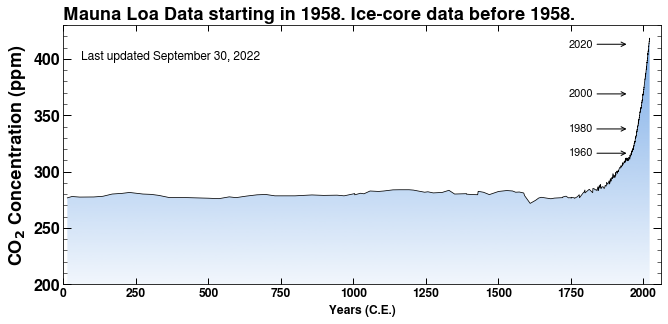

In [45]:
fig = plt.figure()

# Add padding for exterior plot text
ax = plt.axes([0.11, 0.12, 0.83, 0.54])


# ------------------------
# Add gradiant under curve
# ------------------------

# gradiant limits to data limits
data_start_date = min(combined_years)
data_end_date = max(combined_years)

#area_color = '#ACCAE6'
#area_color = '#8CB2E0'
area_color = '#73a7e6'

gradient_fill(combined_years, combined_co2, fill_color=area_color, 
              xmin=data_start_date, ymin=ymin, xmax=data_end_date, 
              ymax=ymax, ax=ax, alpha_bottom=0.1, alpha=1.0)


# -------------
# Plot the data
# -------------

# Set plotting zorder above the gradientZ
ax.plot(combined_years, combined_co2, '-', color='black', linewidth=0.75, zorder=5)


# -------------------
# Set plot properties
# -------------------
set_website_plot_props(ax, fig, xmin, xmax, ymin, ymax, xlabel, ylabel)


# ---------------
# Add date arrows
# ---------------
apply_arrow_annotations(todays_decimal, mlo_date, mlo_co2)

# --------------
# Add inset text
# --------------
inset_text = f'Last updated {todays_date_modyyr}'
add_inset_label(ax, inset_text)


# ---------------
# Add plot titles
# ---------------
add_plot_title(ax, title1, title2)

# ---------------------
# Save plot for website
# ---------------------
fig = plt.gcf()

save_plot_for_website(fig, pdf_file, png_file)


plt.show()

## Download Plots (pdf & png)

In [48]:
def download_files(ev):
    files.download(png_file)
    files.download(pdf_file)

button = widgets.Button(description='Download Files', button_style='primary')
button.on_click(download_files)
display(button)

Button(button_style='primary', description='Download Files', style=ButtonStyle())